<a href="https://colab.research.google.com/github/lizhieffe/language_model/blob/main/Shakespeare_LM_v4_Causal_Mask_%2B_Customized_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
USE_GPU = True

BLOCK_SIZE = 96 # Context length: how many chars do we take to predict the next one?

# Setup GPU

In [67]:
if USE_GPU:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  assert device.type != 'cpu', "GPU is not available"
else:
  device = 'cpu'

print(device)

cuda:0


In [68]:
g_cpu = torch.Generator(device='cpu').manual_seed(2147483647) # for reproducibility
g_device = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

# Util Functions

# Load data

In [69]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read in all the words
text = open('input.txt', 'r').read()

text[:800]

--2023-10-02 05:49:16--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.10’

input.txt.10        100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2023-10-02 05:49:16 (17.8 MB/s) - ‘input.txt.10’ saved [1115394/1115394]



"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to p"

In [70]:
print(f'total char # = {len(text)}')

total char # = 1115394


# Build vocabulary

In [71]:
chars = sorted(list(set(''.join(text))))

stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for c,i in stoi.items()}

assert len(stoi) == len(itos)

vocab_size = len(stoi)

EXPECTED_VOCAB_SIZE = 65
assert vocab_size == EXPECTED_VOCAB_SIZE, f"expected vocab size = {EXPECTED_VOCAB_SIZE}, got {vocab_size}"

In [72]:
# str ---> list of integer
encode = lambda str: [stoi[s] for s in str]

# list of integer ---> str
decode = lambda l: ''.join(itos[i] for i in l)

_test_str = "adb dfd \n"
assert _test_str == decode(encode(_test_str))

# Create DS

In [73]:
n1 = int(len(text) * 0.9)
train_data = encode(text[:n1])
dev_data = encode(text[n1:])

print(f'{len(train_data)=}, {len(dev_data)=}')

len(train_data)=1003854, len(dev_data)=111540


In [74]:
def get_batch(data, batch_size: int, block_size: int):
  """ Sample a batch using Causal style. """
  x_list = []
  y_list = []
  ix = torch.randint(0, len(data)-block_size, (batch_size,), generator=g_cpu)
  X = torch.stack([torch.tensor(data[i:i+block_size]) for i in ix]).to(device)
  Y = torch.stack([torch.tensor(data[i+1:i+1+block_size]) for i in ix]).to(device)
  return X, Y

In [75]:
X, Y = get_batch(train_data, 16, BLOCK_SIZE)

for b in range(3):
  it = 0
  for t in range(X.shape[1]):
    print(f'{decode(X[b, :t+1].tolist())} ---> {decode([Y[b, t].item()])}')
    it += 1
    if it > 7:
      break

e ---> v
ev ---> e
eve ---> r
ever ---> y
every --->  
every  ---> d
every d ---> a
every da ---> n
e ---> s
es ---> h
esh --->  
esh  ---> c
esh c ---> o
esh co ---> m
esh com ---> p
esh comp ---> l
e --->  
e  ---> r
e r ---> e
e re ---> t
e ret ---> i
e reti ---> r
e retir ---> e
e retire ---> d


# Modeling

In [76]:
n_embd = 768 # the dimensionality of the character embedding vectors
d_head = 2 * n_embd # the dim of the transformer's head
N_HIDDEN = n_embd * 4 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

## Model class

In [77]:
# class Net(torch.nn.Module):

#   def __init__(self, vocab_size, d_embd, d_hidden, d_head):
#     """
#     Args:
#       vocab_size: volabulary size
#       d_embd: dim of embedding for the token
#       d_hidden: dim of hidden FFN layers
#       d_head: dim of the transformer head
#     """
#     super().__init__()

#     self.d_head = d_head

#     self.embd = torch.nn.Embedding(
#         num_embeddings=vocab_size,
#         embedding_dim=d_embd
#     )

#     self.key1 = torch.nn.Linear(d_embd, d_head, bias=False)
#     self.query1 = torch.nn.Linear(d_embd, d_head, bias=False)
#     self.value1 = torch.nn.Linear(d_embd, d_head, bias=False)

#     self.linear1 = torch.nn.Linear(d_head, d_hidden, bias=True)
#     self.tanh1 = torch.nn.Tanh()

#     # self.linear1 = torch.nn.Linear(d_embd, d_hidden, bias=True)
#     # self.tanh1 = torch.nn.Tanh()
#     # self.linear2 = torch.nn.Linear(d_hidden, d_hidden, bias=True)
#     # self.tanh2 = torch.nn.Tanh()
#     # self.linear3 = torch.nn.Linear(d_hidden, d_hidden, bias=True)
#     # self.tanh3 = torch.nn.Tanh()
#     self.linear_logit = torch.nn.Linear(d_hidden, vocab_size, bias=True)


#   def forward(self, x, targets=None):
#     """
#     Args:
#       x: (B, T). The input to the model.
#       targets: (B, T). When it is not None, the func calculates and return the
#         loss in additional to other returned item(s)
#     Returns:
#       loss: int
#       logits: (B, T, C)
#     """

#     T = x.shape[-1]
#     tril = torch.tril(torch.ones(T, T)).to(device)

#     xemb = self.embd(x) # (B, T, C)

#     k = self.key1(xemb)  # (B, T, d_head)
#     q = self.query1(xemb) # (B, T, d_head)
#     wei = k @ q.transpose(-2, -1) # (B, T, d_head) @ (B, d_head, T) = (B, T, T)
#     wei = wei.masked_fill(tril==0, float('-inf')) # (B, T, T)
#     wei = wei * self.d_head**-0.5
#     wei = F.softmax(wei, dim=-1) # (B, T, T)

#     v = self.value1(xemb) # (B, T, d_head)
#     # This makes the y[:,t,:], to have the information of the embedding (v)
#     # v[:, u (u<=t), :], but not have the infomration of v[:, w (w>t), :]
#     #
#     # 1. Spread v's information at all t to y[:, any t, :]
#     #
#     # Because v is on rhs of @, its information at different T are spread out to
#     # the different T in y
#     #
#     # Think about (T, T) @ (T, d_head) = (T, d_head)
#     #
#     # a11, a12     b1   a11*b1+a12*b2
#     # a21, a22  @  b2 = a21*b1+a22*b2
#     #
#     # In the result, at T=1, it has b1 and b2, which are the rhs of @'s info at
#     # different T
#     #
#     # 2. Limit y[:, t, :] to not access v[:, w (w>t), :].
#     #
#     # This is done by `tril`
#     y = wei @ v # (B, T, d_head)

#     # It doesn't need tril here, because the lhs and rhs doesn't exchange
#     # information at different T.
#     #
#     # Let's say:
#     # - input is y (B, T, d_head)
#     # - Linear(d_in, d_out) is a matrix l(d_in, d_out), here dim is l(d_head, d_hidden)
#     # - result is z (B, T, d_hidden)
#     #
#     # linear(y) = y @ l = z
#     #
#     # To simplify, ignore B, T=3, d_head=2, d_hidden=1
#     #
#     #         y11 y12         y11*l1+y12*l2
#     # y @ l = y21 y22 @ l1  = y21*l1+y22*l2
#     #         y31 y32   l2    y31*l1+y32*l2
#     #
#     # We can see z[:, T, :] only contains y[:, T, :]'s info
#     #
#     # To summarize this and the previous section
#     #
#     # Z = X @ Y
#     #
#     # Z[T, :] only contains X[T, :]'s info, doesn't contain X[S != T, :]'s infor
#     # Z[T, :] contains Y[at any index, :]'s info
#     y = self.linear1(y) # (B, T, d_hidden)
#     y = self.tanh1(y)

#     logits = self.linear_logit(y) # (B, T, vocab_size)
#     logits = logits.view(-1, logits.shape[-1]) # (B, T, vocab_size)

#     if targets is None:
#       loss = None
#     else:
#       loss = F.cross_entropy(logits, targets.view(-1))

#     return logits.view(-1, T, logits.shape[1]), loss

#   def generate(self, idx, max_new_tokens: int):
#     """Generate new tokens given idx as context.

#     Args:
#       idx: (B, T)
#       max_new_tokens: number of new tokens to generate

#     Returns:
#       (B,T+max_new_tokens)
#     """
#     for _ in range(max_new_tokens):
#       logits, loss = self(idx, targets=None)  # logits: (B, T, vocab_size), loss: None
#       logits = logits[:, -1, :] # (B, vocab_size)
#       prob = F.softmax(logits, dim=1) # (B, vocab_size)
#       idx_next = torch.multinomial(prob, num_samples=1, replacement=False)  # (B, 1)
#       idx = torch.cat((idx, idx_next), dim=1)

#     return idx

# net = Net(vocab_size, d_embd=n_embd, d_hidden=N_HIDDEN, d_head=N_HIDDEN).to(device)

In [78]:
class AttentionBlock(torch.nn.Module):

  def __init__(self, vocab_size, d_in, d_hidden, d_head):
    """
    Args:
      vocab_size: volabulary size
      d_in: dim of input. If this is the immediate next layer of the token
        embedding layer, this is the dim of the embedding for a token.
      d_hidden: dim of hidden FFN layers
      d_head: dim of the transformer head
    """
    super().__init__()

    self.d_head = d_head
    self.key1 = torch.nn.Linear(d_in, d_head, bias=False)
    self.query1 = torch.nn.Linear(d_in, d_head, bias=False)
    self.value1 = torch.nn.Linear(d_in, d_head, bias=False)

    self.linear1 = torch.nn.Linear(d_head, d_hidden, bias=True)
    self.tanh1 = torch.nn.Tanh()
    # Project d_hidden back to d_head as output
    self.proj = torch.nn.Linear(d_hidden, d_head, bias=True)

  def forward(self, x):
    """
    Args:
      x: (B, T, C). The input to the model.
    Returns:
      loss: int
      logits: (B, T, C)
    """

    T = x.shape[-2]
    tril = torch.tril(torch.ones(T, T)).to(device)

    k = self.key1(x)  # (B, T, d_head)
    q = self.query1(x) # (B, T, d_head)
    wei = k @ q.transpose(-2, -1) # (B, T, d_head) @ (B, d_head, T) = (B, T, T)
    wei = wei.masked_fill(tril==0, float('-inf')) # (B, T, T)
    wei = wei * self.d_head**-0.5
    wei = F.softmax(wei, dim=-1) # (B, T, T)

    v = self.value1(x) # (B, T, d_head)
    # This makes the y[:,t,:], to have the information of the embedding (v)
    # v[:, u (u<=t), :], but not have the infomration of v[:, w (w>t), :]
    #
    # 1. Spread v's information at all t to y[:, any t, :]
    #
    # Because v is on rhs of @, its information at different T are spread out to
    # the different T in y
    #
    # Think about (T, T) @ (T, d_head) = (T, d_head)
    #
    # a11, a12     b1   a11*b1+a12*b2
    # a21, a22  @  b2 = a21*b1+a22*b2
    #
    # In the result, at T=1, it has b1 and b2, which are the rhs of @'s info at
    # different T
    #
    # 2. Limit y[:, t, :] to not access v[:, w (w>t), :].
    #
    # This is done by `tril`
    y = wei @ v # (B, T, d_head)

    # It doesn't need tril here, because the lhs and rhs doesn't exchange
    # information at different T.
    #
    # Let's say:
    # - input is y (B, T, d_head)
    # - Linear(d_in, d_out) is a matrix l(d_in, d_out), here dim is l(d_head, d_hidden)
    # - result is z (B, T, d_hidden)
    #
    # linear(y) = y @ l = z
    #
    # To simplify, ignore B, T=3, d_head=2, d_hidden=1
    #
    #         y11 y12         y11*l1+y12*l2
    # y @ l = y21 y22 @ l1  = y21*l1+y22*l2
    #         y31 y32   l2    y31*l1+y32*l2
    #
    # We can see z[:, T, :] only contains y[:, T, :]'s info
    #
    # To summarize this and the previous section
    #
    # Z = X @ Y
    #
    # Z[T, :] only contains X[T, :]'s info, doesn't contain X[S != T, :]'s infor
    # Z[T, :] contains Y[at any index, :]'s info
    y = self.linear1(y) # (B, T, d_hidden)
    y = self.tanh1(y) # (B, T, d_hidden)
    y = self.proj(y) # (B, T, d_head)

    return y

  def generate(self, idx, max_new_tokens: int):
    """Generate new tokens given idx as context.

    Args:
      idx: (B, T)
      max_new_tokens: number of new tokens to generate

    Returns:
      (B,T+max_new_tokens)
    """
    for _ in range(max_new_tokens):
      logits, loss = self(idx, targets=None)  # logits: (B, T, vocab_size), loss: None
      logits = logits[:, -1, :] # (B, vocab_size)
      prob = F.softmax(logits, dim=1) # (B, vocab_size)
      idx_next = torch.multinomial(prob, num_samples=1, replacement=False)  # (B, 1)
      idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [85]:
class Net(torch.nn.Module):

  def __init__(self, vocab_size, d_embd, d_hidden, d_head):
    """
    Args:
      vocab_size: volabulary size
      d_embd: dim of embedding for the token
      d_hidden: dim of hidden FFN layers
      d_head: dim of the transformer head
    """
    super().__init__()

    self.d_head = d_head

    self.embd = torch.nn.Embedding(
        num_embeddings=vocab_size,
        embedding_dim=d_embd
    )
    self.attn1 = AttentionBlock(vocab_size, d_embd, d_hidden, d_head)
    self.attn2 = AttentionBlock(vocab_size, d_head, d_hidden, d_head)
    self.linear_logit = torch.nn.Linear(d_head, vocab_size, bias=True)


  def forward(self, x, targets=None):
    """
    Args:
      x: (B, T). The input to the model.
      targets: (B, T). When it is not None, the func calculates and return the
        loss in additional to other returned item(s)
    Returns:
      loss: int
      logits: (B, T, C)
    """

    T = x.shape[-1]
    tril = torch.tril(torch.ones(T, T)).to(device)

    xemb = self.embd(x) # (B, T, C)

    y = self.attn1(xemb)
    y = self.attn2(y)

    logits = self.linear_logit(y) # (B, T, vocab_size)
    logits = logits.view(-1, logits.shape[-1]) # (B, T, vocab_size)

    if targets is None:
      loss = None
    else:
      loss = F.cross_entropy(logits, targets.view(-1))

    return logits.view(-1, T, logits.shape[1]), loss

  def generate(self, idx, max_new_tokens: int):
    """Generate new tokens given idx as context.

    Args:
      idx: (B, T)
      max_new_tokens: number of new tokens to generate

    Returns:
      (B,T+max_new_tokens)
    """
    for _ in range(max_new_tokens):
      logits, loss = self(idx, targets=None)  # logits: (B, T, vocab_size), loss: None
      logits = logits[:, -1, :] # (B, vocab_size)
      prob = F.softmax(logits, dim=1) # (B, vocab_size)
      idx_next = torch.multinomial(prob, num_samples=1, replacement=False)  # (B, 1)
      idx = torch.cat((idx, idx_next), dim=1)

    return idx

net = Net(vocab_size, d_embd=n_embd, d_hidden=N_HIDDEN, d_head=N_HIDDEN).to(device)

In [86]:
_total_params = 0

for p in net.parameters():
  _total_params += p.nelement()

print(f'Total params = {_total_params}')

Total params = 73400129


## Define optimizer

In [87]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train

In [88]:
max_steps = 700000
batch_size = 64
lossi = []
lossi_dev = []
ud = []
log_interval = 50

running_loss = 0.0
running_loss_dev = 0.0
running_loss_steps = 0

for i in range(max_steps):

  # Forward
  Xb, Yb = get_batch(train_data, batch_size, BLOCK_SIZE)
  optimizer.zero_grad()
  logits, loss = net(Xb, targets=Yb)

  # Loss
  # print(f'{outputs.shape=}, {Yb.shape=}')
  running_loss += loss.item()
  running_loss_steps += 1

  # Eval dev DS
  Xb_dev, Yb_dev = get_batch(dev_data, batch_size, BLOCK_SIZE)
  logits_dev, loss_dev = net(Xb_dev, targets=Yb_dev)
  running_loss_dev += loss_dev.item()

  # Update
  loss.backward()
  optimizer.step()

  # Track status
  if i % log_interval == 0:
    print(f'{i}/{max_steps}: training loss={running_loss/running_loss_steps:.4f}, dev loss={running_loss_dev/running_loss_steps:.4f}')
    running_loss = 0.0
    running_loss_dev = 0.0
    running_loss_steps = 0

  lossi.append(loss.log10().item())
  lossi_dev.append(loss_dev.log10().item())

0/700000: training loss=4.1777, dev loss=4.1778
50/700000: training loss=4.1522, dev loss=4.1528
100/700000: training loss=4.0704, dev loss=4.0746
150/700000: training loss=3.8758, dev loss=3.8872
200/700000: training loss=3.5036, dev loss=3.5350
250/700000: training loss=3.3699, dev loss=3.4177
300/700000: training loss=3.3470, dev loss=3.3819
350/700000: training loss=3.3295, dev loss=3.3770
400/700000: training loss=3.3291, dev loss=3.3656
450/700000: training loss=3.3246, dev loss=3.3606
500/700000: training loss=3.3146, dev loss=3.3642
550/700000: training loss=3.3197, dev loss=3.3579
600/700000: training loss=3.3097, dev loss=3.3591
650/700000: training loss=3.3105, dev loss=3.3551
700/700000: training loss=3.3109, dev loss=3.3501
750/700000: training loss=3.3071, dev loss=3.3387
800/700000: training loss=3.3127, dev loss=3.3506
850/700000: training loss=3.3096, dev loss=3.3486
900/700000: training loss=3.3074, dev loss=3.3450
950/700000: training loss=3.3091, dev loss=3.3450
100

KeyboardInterrupt: ignored

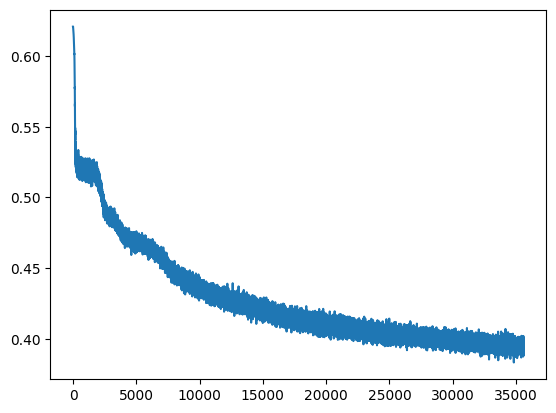

In [89]:
plt.plot(lossi)

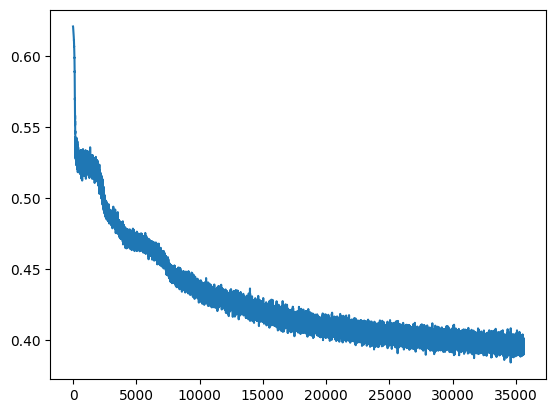

In [90]:
plt.plot(lossi_dev)

In [91]:
torch.cuda.empty_cache()

# Sample the model

In [92]:
g_gpu = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

# 0, which is new line char, is a reasonable start (seed) char
idx = torch.tensor([[0]]).to(device)
new_idx = net.generate(idx, 1000)

print(decode(new_idx.view(-1).tolist()))


ORGANISy ea gialy muit qeeprs aurantherarre co mue cond
ICofagitmamathed fadeifou, see oskghe.
Ofr
Gome f ame,ts, pusp; wof wing hare
Fownthalo, ros rove omirtk demareikuir alathake love n inkins.
KOL ds g?
IULoe:
An teind ir a, olit.
BCO:
AWhourlertin, thors KK:
Thy?

AROn w thad wis elde ldeaboupr tonor and, oran fofout.

CETay t,

Anigeso brtlle, of achase te pe seeangelougheat thouts is ft Whe'of dig wno hethesuleherke vey thay, were
Whes MHE'sp, pre
NUUA:
Thay m med donke wnvefome ar me hingnd subuche, d, by, dso IThin
Fo sede hthal tsthy chais.
Hator fewereat bowake by, jowiny iksenef norefing t'le woungndrang. w ind!
Toulorer:

UAnithepere, crn f hot my o' whe we y,
Vo t e anor touse s m! k, Fel
Whateeg, kanth y ffugrarsthour's e nisulon my Wh w he, ore ad d:-n t IN ke, ondorgare m iero o
Tod tacome
BI:
Whe thend tariveg itouces,
Hend muu I ndil, tor alkis ESin co pumaldeell h, dugomor:

Por bdoo thed.

Fry teen.
KOimandongesity colinours be.
Alfoft
IISind Cola
IBEThof werll, h